Code based on AE with pytorch lighting tutorial: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

# Imports

In [21]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

from utils import CKA, MinFrob

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from procrustes import orthogonal

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/cls_sim"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


# Dataset

In [3]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
print(train_dataset.data.shape)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

NUM_BATCHES_TRAIN = len(train_loader)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

EPOCHS = 20

Global seed set to 42


torch.Size([60000, 28, 28])


# Model

In [4]:
class CNN(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 num_labs: int,
                 linear_hidden_dims: list,
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        layers =  [nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=3, stride=2), # 28x28 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            ]
        
        layer_sizes = [2*16*c_hid] + linear_hidden_dims
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1],
                                 layer_sizes[layer_index]),
                        act_fn()]
        
        layers += [nn.Linear(layer_sizes[-1], num_labs)]
        
        self.net = nn.ModuleList(layers)
    
    
    def forward(self, x):
        for blk in self.net:
            x = blk(x)
            
        return x
    
    def detailed_forward(self, x):
        res = [x]
        for blk in self.net:
            x = blk(x)
            res.append(x.detach().reshape(x.shape[0], -1))
            
        return res

In [5]:
class LitCNN(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 num_labs: int = 10, 
                 seed : int = 42,
                 linear_hidden_dims : list = [],
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        
        pl.seed_everything(seed)

        # Creating encoder and decoder
        self.net = CNN(num_input_channels, 
                        base_channel_size, 
                        num_labs,
                        linear_hidden_dims)
                
        self.loss_module = nn.CrossEntropyLoss()
        
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
    
    def forward(self, x):
       
        return self.net(x) 
        
    def detailed_forward(self, x):
        """
        The forward function takes in an image and returns a list of all the activations
        """
        
        return self.net.detailed_forward(x)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        
        """scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                          base_lr=5e-5,
                                          max_lr=1e-3,
                                          step_size_up=(4*NUM_BATCHES_TRAIN)//2,
                                          cycle_momentum=False,
                                          mode="triangular2")"""
                                          
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-3,
                                                total_steps=EPOCHS)
        
       
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.net(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_loss", loss, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.net(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.net(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

# Training

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object in PyTorch Lightning which will add reconstructions every $N$ epochs to our tensorboard:

In [6]:
def train_network(seed=24, linear_hidden_dims=[]):
    
    # Create a PyTorch Lightning trainer with the generation callback
    dim_tit = "-".join(str(l) for l in (linear_hidden_dims)) 
    
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"MNIST_{dim_tit}_seed{seed}"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=EPOCHS, 
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    LearningRateMonitor("epoch")])
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    
    model = LitCNN(base_channel_size=28,
                        seed=seed,
                        linear_hidden_dims=linear_hidden_dims,
                        num_input_channels=1, 
                        width=28, 
                        height=28
                        )
    
   
    trainer.fit(model, train_loader, val_loader)
    
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    
    return model, result
    

In [7]:
linear_hidden_dims = [512, 256, 128, 32]

for seed in [42, 200, 121, 2013, 2023]:
    model_ld, result_ld = train_network(linear_hidden_dims=linear_hidden_dims,
                                        seed=seed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | CNN              | 706 K  | [2, 1, 28, 28] | [2, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
706 K     Trainable params
0   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 200
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | CNN              | 706 K  | [2, 1, 28, 28] | [2, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
706 K     Trainable params
0  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 121
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | CNN              | 706 K  | [2, 1, 28, 28] | [2, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
706 K     Trainable params
0  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 2013
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | CNN              | 706 K  | [2, 1, 28, 28] | [2, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
706 K     Trainable params
0 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 2023
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | CNN              | 706 K  | [2, 1, 28, 28] | [2, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
706 K     Trainable params
0 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

When linear dims are: -512-256-128-32-10-

|   **seed**   | **42** | **121** | **200** | **2013** | **2023** |
|:------------:|:------:|:-------:|:-------:|:----------:|:----------:|
| **Test Acc** |  0.9888  |  0.9908  |  0.9878  |   0.9897  |   0.9895  |

In [ ]:
# %tensorboard --logdir saved_models/ae_sim/MNIST_2_seed2013/lightning_logs/version_0

# Similarity study

In [1]:
FIG_PATH = "Visualization/sim_cls/"

In [26]:
models = dict()
# SEEDS = [42, 200, 121]
SEEDS = [42, 200, 121, 2013, 2023]

linear_hidden_dims = [512, 256, 128, 32]
dim_tit = "-".join(str(l) for l in linear_hidden_dims) 

for seed in SEEDS:
    model_path = f"/MNIST_{dim_tit}_seed{seed}/lightning_logs/version_0/checkpoints/epoch=19-step=3900.ckpt"
    models[seed] = LitCNN.load_from_checkpoint(CHECKPOINT_PATH + model_path).net

sim_test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=True)

Global seed set to 42
Global seed set to 200
Global seed set to 121
Global seed set to 2013
Global seed set to 2023


## CKA

In [10]:
def cka_analysis(models, dataloader, dim_tit):
    seeds = [str(k) for k in models.keys()]
    fig = plt.figure(figsize=(2*len(seeds), 2*len(seeds)))

    for i, (seed1, model1) in enumerate(models.items()):
        for j, (seed2, model2) in enumerate(models.items()):
            
            if(j>=i):
                cka = CKA(model1, model2,
                        model1_name=f"Seed {seed1}",
                        model2_name=f"Seed {seed2}",
                        model1_layers=[name for name, _ in model1.named_modules()
                                        if name.startswith("net.")],
                        model2_layers=[name for name, _ in model2.named_modules()
                                        if name.startswith("net.")],
                        device='cuda')

                cka.compare(dataloader)
                
                ax = plt.subplot2grid((len(SEEDS), len(SEEDS)), (i,j)) 
                cka.plot_results(ax_=ax)
                    
                if j==i:
                    ax.set_ylabel(f"Layers Seed {seed2}")
                    ax.set_xlabel(f"Layers Seed {seed1}")

    fig.suptitle(f"CKA analysis (Linear layers: {dim_tit})")
    plt.tight_layout()
    seeds_str = "_".join(seeds)
    fig.savefig(FIG_PATH + f"cka_{dim_tit}__{seeds_str}.png")
    plt.show()                                

| Comparing features |: 100%|██████████| 39/39 [00:16<00:00,  2.30it/s]
| Comparing features |: 100%|██████████| 39/39 [00:17<00:00,  2.19it/s]
| Comparing features |: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s]
| Comparing features |: 100%|██████████| 39/39 [00:17<00:00,  2.27it/s]
| Comparing features |: 100%|██████████| 39/39 [00:16<00:00,  2.31it/s]
| Comparing features |: 100%|██████████| 39/39 [00:16<00:00,  2.30it/s]


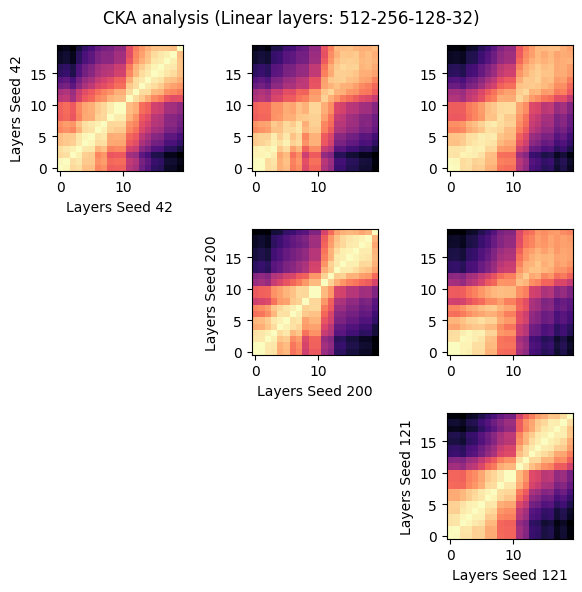

In [15]:
cka_analysis(models, sim_test_loader, dim_tit)

## Distance matrix analysis

In [12]:
def frob_analysis(models, dataloader, dim_tit):
    seeds = [str(k) for k in models.keys()]
    fig = plt.figure(figsize=(2*len(seeds), 2*len(seeds)))

    for i, (seed1, model1) in enumerate(models.items()):
        for j, (seed2, model2) in enumerate(models.items()):
            
            if(j>=i):
                frobSim = MinFrob(model1, model2,
                        model1_name=f"Seed {seed1}",
                        model2_name=f"Seed {seed2}",
                        model1_layers=[name for name, _ in model1.named_modules()
                                        if name.startswith("net.")],
                        model2_layers=[name for name, _ in model2.named_modules()
                                        if name.startswith("net.")],
                        device='cuda')

                frobSim.compare(dataloader)
                
                ax = plt.subplot2grid((len(SEEDS), len(SEEDS)), (i,j)) 
                frobSim.plot_results(ax_=ax, cmap='magma_r')
                    
                if j==i:
                    ax.set_ylabel(f"Layers Seed {seed2}")
                    ax.set_xlabel(f"Layers Seed {seed1}")

    fig.suptitle(f"Minimum Frobenius distance analysis (Linear layers: {dim_tit})")
    plt.tight_layout()
    seeds_str = "_".join(seeds)
    fig.savefig(FIG_PATH + f"frob_{dim_tit}__{seeds_str}.png")
    plt.show() 

| Comparing features |: 100%|██████████| 39/39 [00:08<00:00,  4.62it/s]
| Comparing features |: 100%|██████████| 39/39 [00:08<00:00,  4.70it/s]
| Comparing features |: 100%|██████████| 39/39 [00:08<00:00,  4.53it/s]
| Comparing features |: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s]
| Comparing features |: 100%|██████████| 39/39 [00:09<00:00,  4.05it/s]
| Comparing features |: 100%|██████████| 39/39 [00:08<00:00,  4.61it/s]


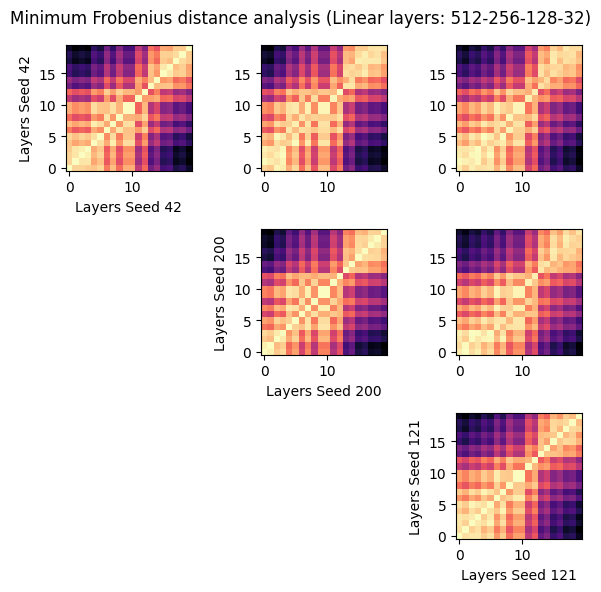

In [16]:
frob_analysis(models, sim_test_loader, dim_tit)

## Visualization

In [28]:
def vis_latent(models, dataloader, dim_tit, device="cpu", embedding_type="pca"):
    
    def embed_imgs(model):
    
        # Encode all images in the data_laoder using model, and return both images and encodings
        embed_list, lbs_list = [], []
        model.to(device)
        model.eval()
        
        for imgs, labls in tqdm(dataloader, desc="Encoding images", leave=False):
            with torch.no_grad():
                imgs = imgs.to(device)
                idx =  0
                while idx <= 10:
                    imgs = model.net[idx](imgs)
                    idx +=1
                
            embed_list.append(imgs)
            lbs_list.append(labls)
    
        lbs_tensor, idx = torch.sort(torch.cat(lbs_list, dim=0)) 
        lbs_tensor = lbs_tensor.cpu().numpy()
        embed_tensor = torch.cat(embed_list, dim=0)[idx, ...].cpu().numpy() 
        
        if embed_tensor.shape[-1] != 2:
            scaler = StandardScaler(with_std=False)
            embed_tensor_scaled = scaler.fit_transform(embed_tensor)
            if embedding_type == "pca":
                # Reduce from 4 to 2 features with PCA
                pca = PCA(n_components=2)
                # Fit and transform data
                embed_tensor = pca.fit_transform(embed_tensor_scaled)
            else:
                embed_tensor = TSNE(n_components=2, learning_rate='auto',
                        init='random', perplexity=3).fit_transform(embed_tensor_scaled)
        
        return embed_tensor, lbs_tensor
    
    
    seeds = [str(k) for k in models.keys()]
    fig  = plt.figure(figsize=(15, 10))

    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    ax = [ax1,ax2, ax3, ax4, ax5]

    for i, (seed_, model_) in enumerate(models.items()):
        sorted_embeds_test, sorted_labels_test = embed_imgs(model_)
        ax[i].scatter(sorted_embeds_test[:, 0], sorted_embeds_test[:, 1],
                    c=sorted_labels_test,
                    alpha=.4, s=3**2, cmap='tab10')

        ax[i].axis('equal')
        ax[i].set_title(f"Seed {seed_}")

    fig.suptitle(f"Latent space visualization (Linear layers: {dim_tit})")
    plt.tight_layout()
    seeds_str = "_".join(seeds)
    fig.savefig(FIG_PATH + f"vis_{embedding_type}_{dim_tit}__{seeds_str}.png")
    plt.show()

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

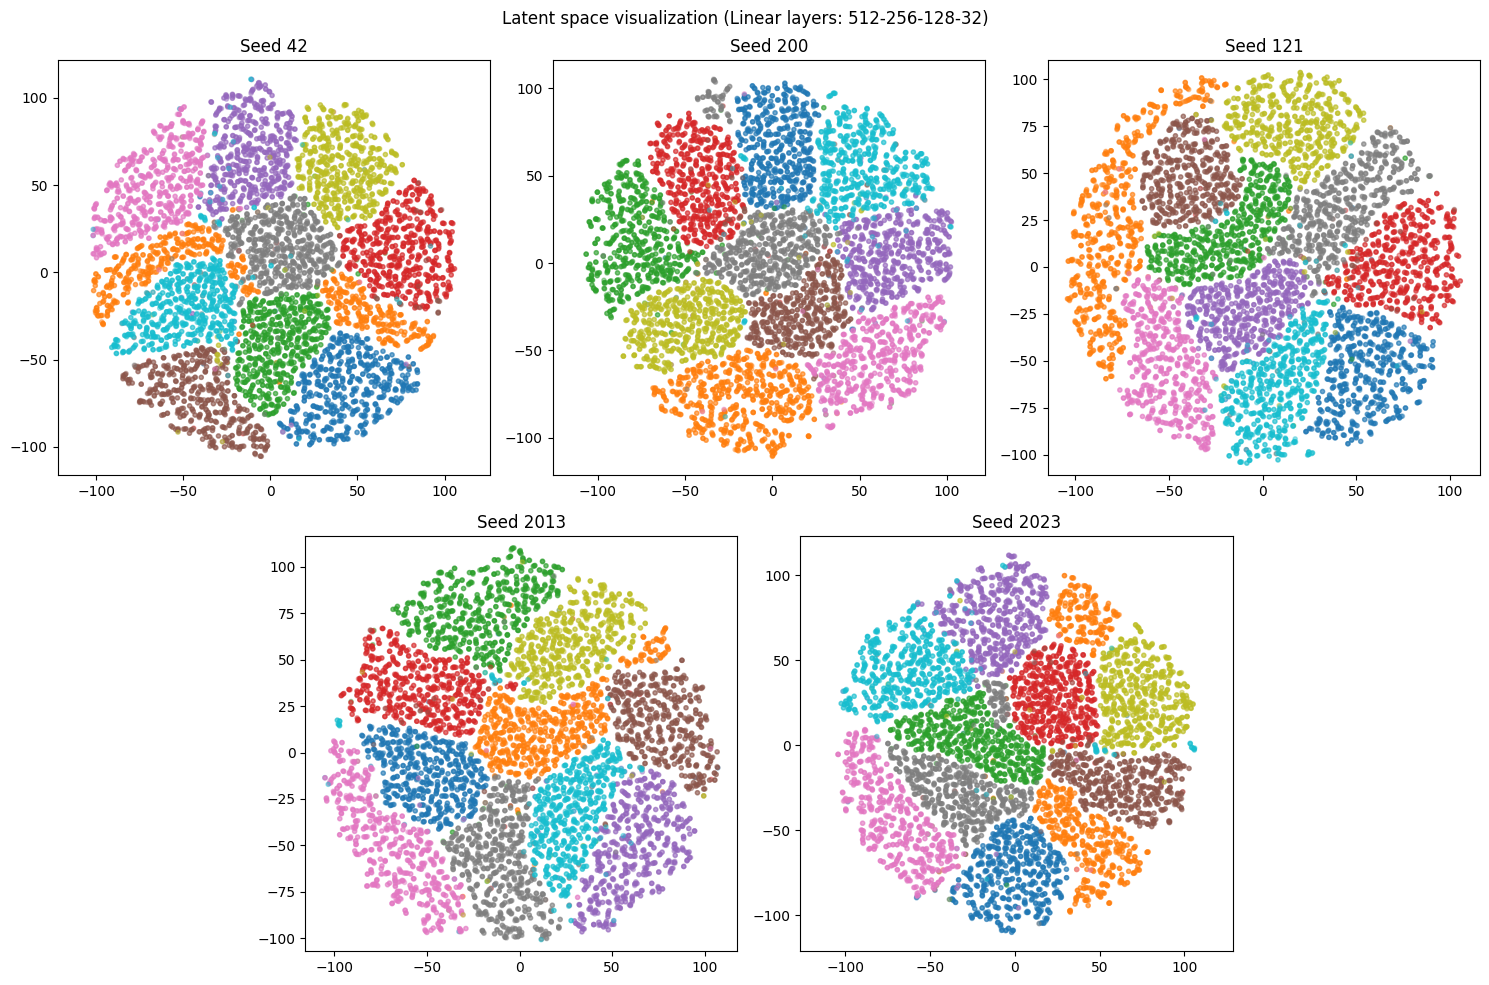

In [30]:
vis_latent(models, sim_test_loader, dim_tit, device=device, embedding_type="tsne")

## Procrustes analysis

In [ ]:
def procrustes_analysis(models, dataloader, dim_tit, device="cpu"):
    
    def embed_imgs(model):
    
        # Encode all images in the data_laoder using model, and return both images and encodings
        embed_list, lbs_list = [], []
        model.to(device)
        model.eval()
        
        for imgs, labls in tqdm(dataloader, desc="Encoding images", leave=False):
            with torch.no_grad():
                imgs = imgs.to(device)
                idx =  0
                while idx <= 10:
                    imgs = model.net[idx](imgs)
                    idx +=1
                    
            embed_list.append(imgs)
            lbs_list.append(labls)
    
        lbs_tensor = torch.cat(lbs_list, dim=0).cpu().numpy()
        embed_tensor = torch.cat(embed_list, dim=0).cpu().numpy() 
        
        return embed_tensor, lbs_tensor

    embeds_test_list, labels_test_list = [], []
    for i, (seed_, model_) in enumerate(models.items()):
        sorted_embeds_test, sorted_labels_test = embed_imgs(model_)
        embeds_test_list.append(sorted_embeds_test)
        labels_test_list.append(sorted_labels_test)
    
    seeds = [str(k) for k in models.keys()]
    num_seeds = len(seeds)
    fig = plt.figure(figsize=(3*num_seeds, 3*num_seeds))

    
    col = []
    for index in range(len(seeds)):
    # loop over colors and change the last entry in descending order 3 times
            col.append(list(plt.cm.tab10(index)))
    

    for j, (seed1, model1) in enumerate(reversed(models.items())):
        j = num_seeds - j - 1
        
        if embeds_test_list[j].shape[-1] != 2:
            pca = PCA(n_components=2)
            
        embed_new_b = None
        
        for i, (seed2, model2) in enumerate(reversed(models.items())):
            i = num_seeds - i - 1
            if(j>=i):
                result = orthogonal(embeds_test_list[i], embeds_test_list[j],
                                    translate=True, scale=True)
                aq = np.dot(result.new_a, result.t)
                            
                ax = plt.subplot2grid((len(SEEDS), len(SEEDS)), (i,j)) 
                
                if j==i:
                    # Fit and transform data
                    if embeds_test_list[j].shape[-1] != 2:
                        embed_new_b = pca.fit_transform(result.new_b)
                    else:
                        embed_new_b = result.new_b
                        
                    ax.scatter(embed_new_b[:,0], embed_new_b[:, 1], alpha=.1, s=3**2,
                            c=labels_test_list[i], cmap="tab10")
                    ax.set_title("Standarized original")
                    ax.set_ylabel(f"Layers Seed {seed2}")
                    ax.set_xlabel(f"Layers Seed {seed1}")
                else:
                    if embeds_test_list[i].shape[-1] != 2:
                        embed_aq = pca.fit_transform(aq)
                    else:
                        embed_aq = aq
                    
                    ax.scatter(embed_new_b[:,0], embed_new_b[:, 1], alpha=.2, s=3**2, c="tab:grey")
                    ax.scatter(embed_aq[:,0], embed_aq[:, 1], alpha=.1, s=3**2, color=col[i])
                    ax.set_title("Procrustes Error {:.2f}".format(result.error))

    fig.suptitle(f"Procrustes analysis (Linear layers: {dim_tit})", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    seeds_str = "_".join(seeds)
    fig.savefig(FIG_PATH + f"procrustes_{dim_tit}__{seeds_str}.png")
    plt.show()

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/39 [00:00<?, ?it/s]

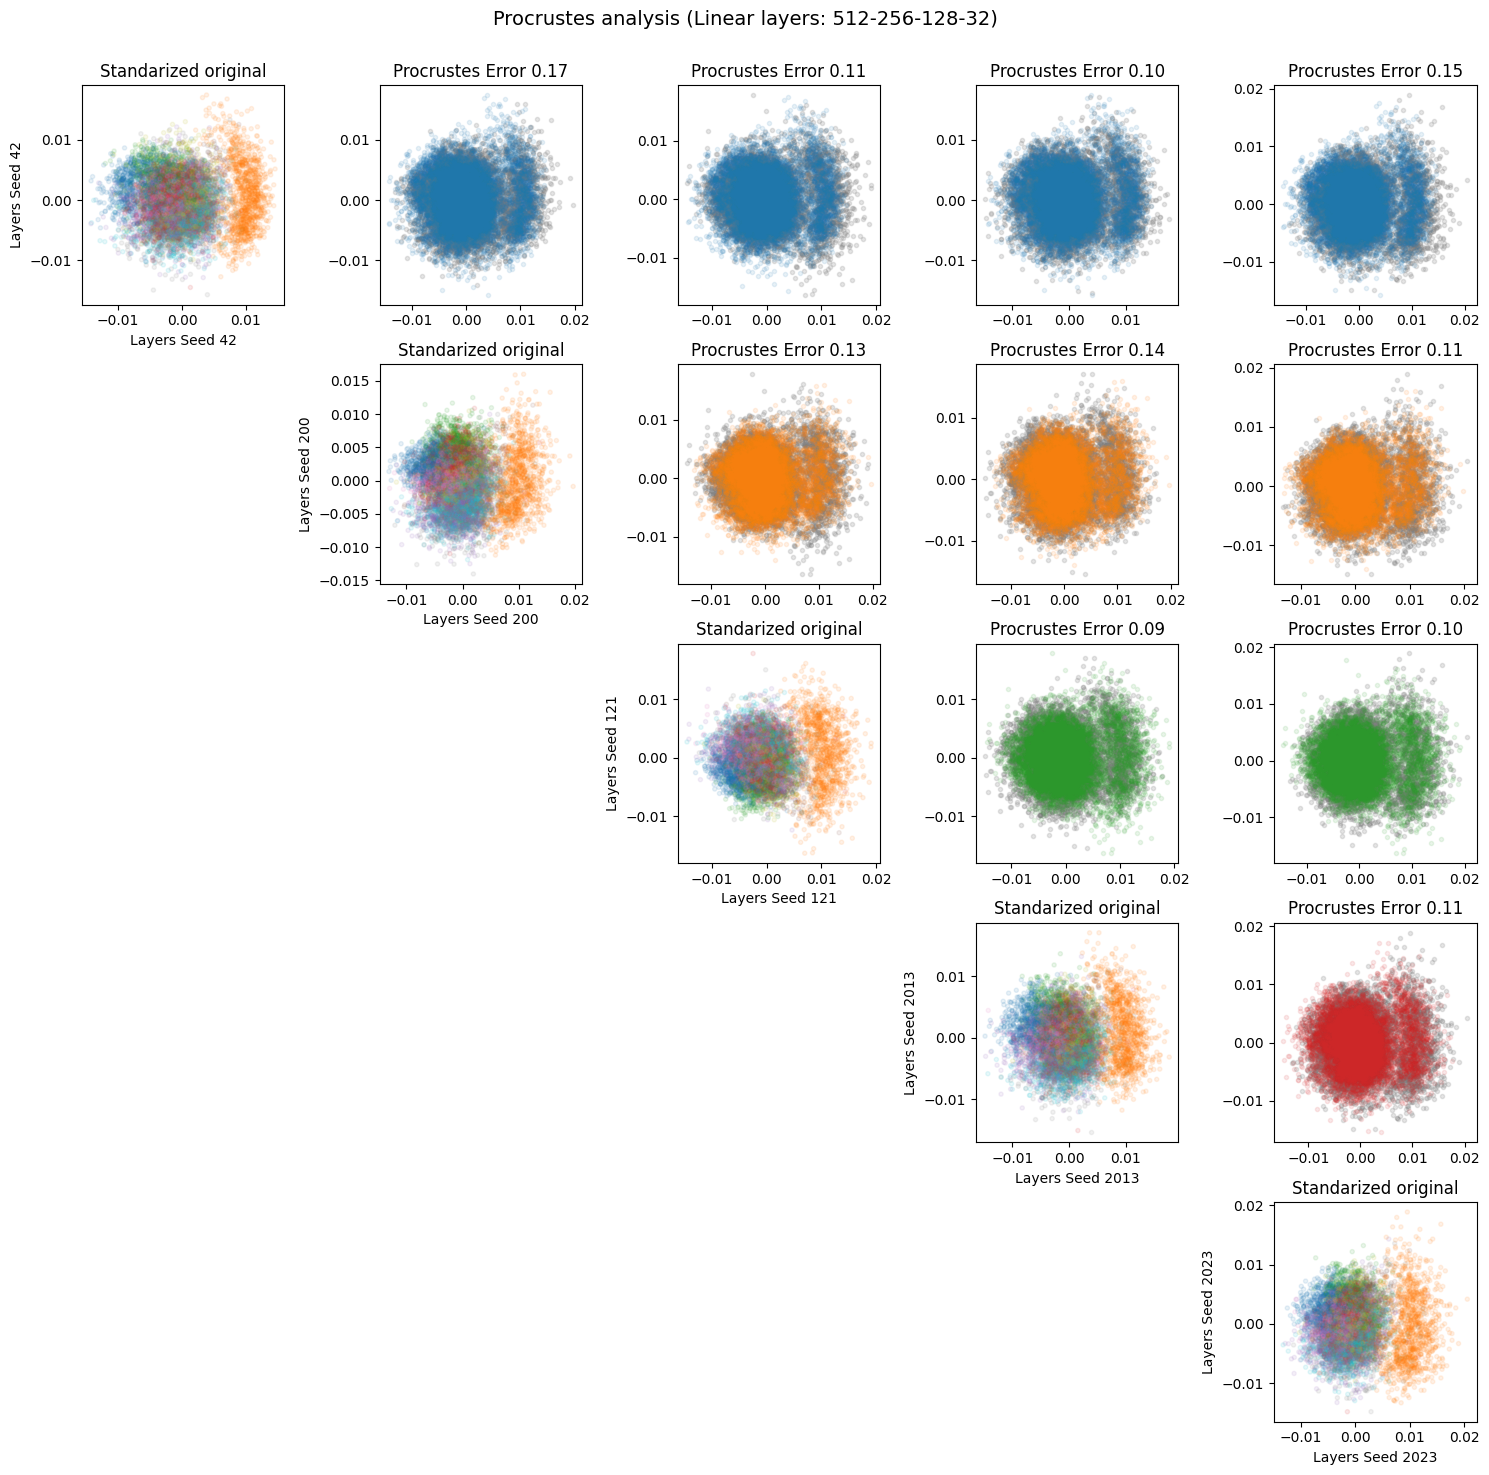

In [ ]:
procrustes_analysis(models, sim_test_loader, dim_tit, device=device)